Amruta Mahendra Parulekar 20d070009

In [322]:
#IMPORTING LIBRARIES
import math
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from scipy.io import wavfile
import scipy.signal as signal
from IPython.display import Audio, display

#MOUNTING GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

#READING THE WAV FILE
read = wavfile.read('/content/drive/MyDrive/Colab Notebooks/Speech/uh.wav')
Fs = read[0]
inp = read[1]



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


448


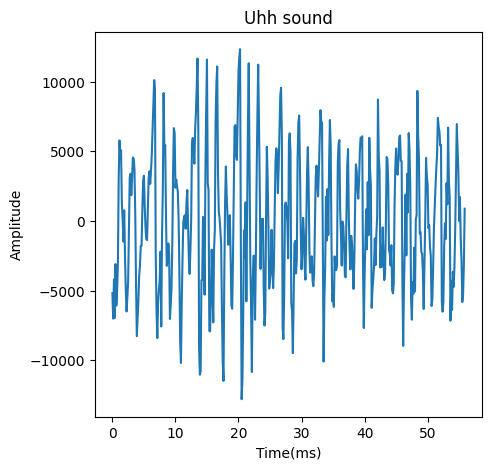

In [323]:
#PLAYING AND PLOTTING THE SOUND
print (len(inp))
t=np.arange(0,56,0.125)
plt.plot(t,inp)
plt.xlabel('Time(ms)')
plt.ylabel('Amplitude')
plt.title('Uhh sound')

Audio(np.asfarray(inp),rate=8000)

#1. Apply pre-emphasis to the signal.

Pre-emphasis: High pass filter

 $P(z)=1-αz^{-1}$ , α=0.95

In [324]:
#APPLYING PREEMPHASIS USING THE DIFFERENCE EQUATION
pe=np.zeros_like(inp)
for i in range(447):
  if (i==0 or i==1):
    pe[i]=inp[i]
  else:
    pe[i]=(inp[i]-0.95*inp[i-1])

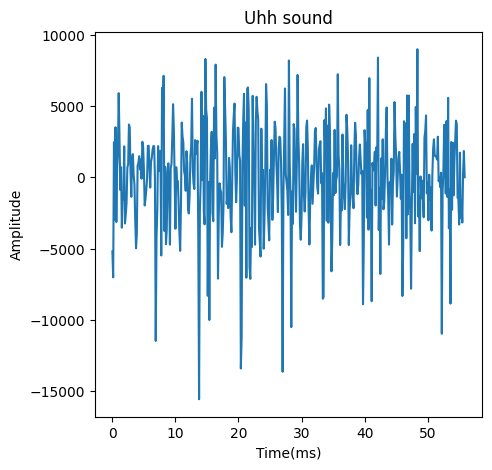

In [325]:
#PLOTTING AND PLAYING THE SOUND AFTER PREEMPHASIS
plt.plot(t,pe)
plt.xlabel('Time(ms)')
plt.ylabel('Amplitude')
plt.title('Uhh sound')

Audio(np.asfarray(pe),rate=8000)

#2. Next, compute and plot a single narrowband magnitude spectrum slice using a Hamming window of duration = 30 ms on a segment near the centre of the given audio file.

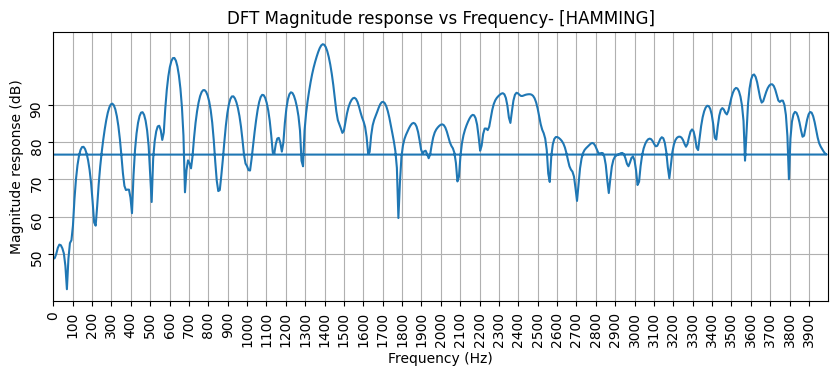

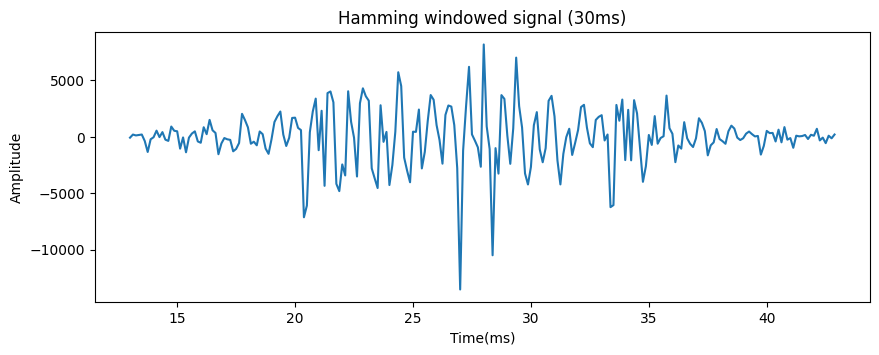

In [326]:
clip=pe[104:344]
samples=int(0.03*8000)
win=clip*np.hamming(samples)
dft=np.fft.fft(win,1024)
freq=np.fft.fftfreq(dft.shape[-1],0.000125)

#PLOTTING SPECTRUM AFTER HAMMING WINDOW
plt.rcParams["figure.figsize"] = [10, 3.50]
plt.plot(freq,20*np.log10(np.abs(dft)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude response (dB)')
plt.title('DFT Magnitude response vs Frequency- [HAMMING]')
plt.xlim(0,4000)
plt.xticks(np.arange(0,4000,100),rotation='vertical')
plt.yticks(np.arange(50,100,10),rotation='vertical')
plt.grid("True")
plt.show()

#PLOTTING WAVEFORM AFTER HAMMING WINDOW
t=np.arange(13,43,0.125)
plt.rcParams["figure.figsize"] = [10, 3.50]
plt.plot(t,win)
plt.xlabel('Time(ms)')
plt.ylabel('Amplitude')
plt.title('Hamming windowed signal (30ms)')
plt.show()

#3. With the same 30 ms segment of part 2, compute the autocorrelation coefficients required for the LPC calculation up to p=10. Use the Levinson-Durbin recursion to compute the LP coefficients from the autocorrelation coefficients for each order p = 2,4,6,8,10. Plot error signal energy (i.e. square of gain) vs p.


479


Text(0, 0.5, 'magnitude')

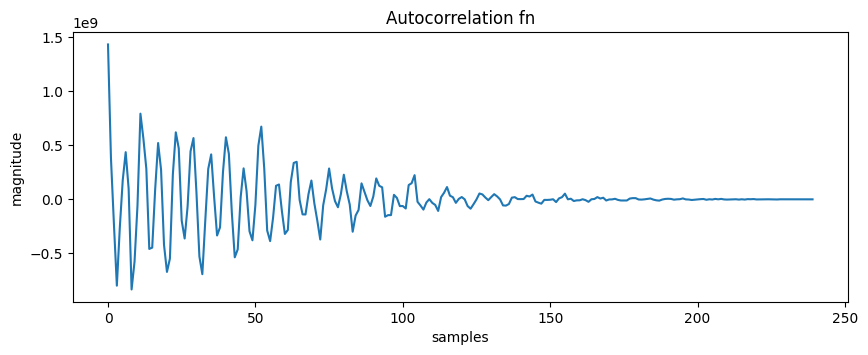

In [327]:
#CALCULATING AUTOCORRELATION FUNCTION
acf=np.correlate(win,win,mode='full')
print(len(acf))
acffinal=acf[239:]
plt.plot(acffinal)
plt.title('Autocorrelation fn')
plt.xlabel('samples')
plt.ylabel('magnitude')

P=2,4,6,8,10

In [238]:
#LEVINSON DURBIN RECURSION TO CALCULATE LINEAR PREDICTION COEFFICIENTS AND ENERGY
energy = np.zeros(11)
coeffs = np.zeros((11,11))
for i in range (11):
 if (i==0):
  energy[i]=acffinal[i]
  coeffs[i][0] = 1
 elif (i==1):
  energy[i] = (1-(acffinal[i]/energy[i-1])**2)*energy[i-1]
  coeffs[i][i] = acffinal[i]/energy[i-1]
  coeffs[i][0] = 1
 else:
  sum1 = 0
  for j in range(1, i):
   sum1 = sum1 + acffinal[i-j]*coeffs[i-1][j]
  energy[i] = (1-((acffinal[i] - sum1)/energy[i-1])**2)*energy[i-1]
  coeffs[i][i] = (acffinal[i] - sum1)/energy[i-1]
  for j in range(1, i):
   coeffs[i][j] = coeffs[i-1][j] - ((acffinal[i] - sum1)/energy[i-1]) * coeffs[i-1][i-j]
  coeffs[i][0] = 1

print('p=2 coeffs:',coeffs[2])
print('p=2 energy:',energy[2])
print('p=4 coeffs:',coeffs[4])
print('p=4 energy:',energy[4])
print('p=6 coeffs:',coeffs[6])
print('p=6 energy:',energy[6])
print('p=8 coeffs:',coeffs[8])
print('p=8 energy:',energy[8])
print('p=10 coeffs:',coeffs[10])
print('p=10 energy:',energy[10])

p=2 coeffs: [ 1.          0.33218708 -0.24435601  0.          0.          0.
  0.          0.          0.          0.          0.        ]
p=2 energy: 1249994399.3396456
p=4 coeffs: [ 1.          0.25147744 -0.07033841 -0.52197375  0.08433003  0.
  0.          0.          0.          0.          0.        ]
p=4 energy: 925402217.622042
p=6 coeffs: [ 1.          0.24948148 -0.04535803 -0.53841457  0.0718214   0.0518586
 -0.03744949  0.          0.          0.          0.        ]
p=6 energy: 922429285.8345073
p=8 coeffs: [ 1.          0.19806722 -0.05722453 -0.4977394   0.0624271  -0.34335389
 -0.05164169  0.11495941 -0.73494829  0.          0.        ]
p=8 energy: 422300572.83804315
p=10 coeffs: [ 1.          0.15581751 -0.03421939 -0.50329878  0.04388539 -0.33204932
 -0.08209565  0.12277685 -0.72207599 -0.06275083  0.02238496]
p=10 energy: 420605064.0791376


Text(0.5, 1.0, 'Error Signal Energy vs Poles')

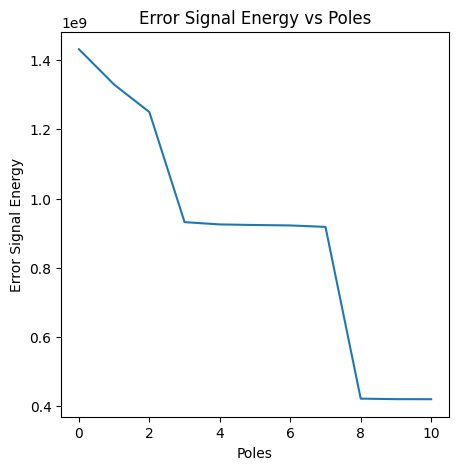

In [239]:
#PLOTTING ERROR SIGNAL ENERGY VS NO. OF POLES
p = [0,1,2,3,4,5,6,7,8,9,10]
plt.rcParams["figure.figsize"] = [5,5]
plt.plot(p,energy)
plt.xlabel("Poles")
plt.ylabel("Error Signal Energy")
plt.title("Error Signal Energy vs Poles")

Text(0.5, 1.0, 'Error Signal Energy(dB) vs Poles')

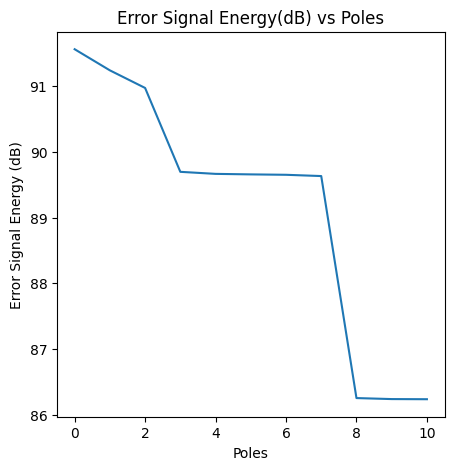

In [240]:
#PLOTTING ERROR SIGNAL ENERGY VS NO. OF POLES
p = [0,1,2,3,4,5,6,7,8,9,10]
plt.rcParams["figure.figsize"] = [5,5]
plt.plot(p,10*np.log10(energy))
plt.xlabel("Poles")
plt.ylabel("Error Signal Energy (dB)")
plt.title("Error Signal Energy(dB) vs Poles")



#4. Show the pole-zero plots of the estimated all-pole filter for p=6,10; comment

In [250]:
#COEFFICIENTS FOR P=6
print('p=6 coeffs:',coeffs[6])

p=6 coeffs: [ 1.          0.24948148 -0.04535803 -0.53841457  0.0718214   0.0518586
 -0.03744949  0.          0.          0.          0.        ]


$H(z)= \frac{1}{1-0.24948148z^{-1}+0.04535803z^{-2}+0.53841457z^{-3}-0.0718214z^{-4}-0.0518586z^{-5}+0.03744949z^{-6}}$

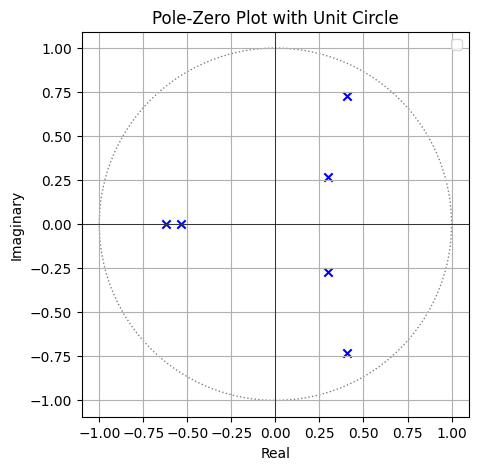

In [251]:
#POLE ZERO PLOT FOR P=6
p=np.roots([1, -0.24948148, +0.04535803, +0.53841457,  -0.0718214,   -0.0518586,
 +0.03744949])

plt.scatter(p.real, p.imag, color='blue', marker='x')
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='dotted')
plt.gca().add_patch(circle)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid()
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.legend()
plt.title('Pole-Zero Plot with Unit Circle')
plt.axis('equal')  # Make the aspect ratio equal for the plot
plt.show()

In [253]:
#COEFFS FOR P=10
print('p=10 coeffs:',coeffs[10])

p=10 coeffs: [ 1.          0.15581751 -0.03421939 -0.50329878  0.04388539 -0.33204932
 -0.08209565  0.12277685 -0.72207599 -0.06275083  0.02238496]


$H(z)= \frac{1}{1-0.15581751z^{-1}+0.03421939z^{-2}+0.50329878z^{-3}-0.04388539z^{-4}+ 0.33204932z^{-5}+0.08209565z^{-6}-0.12277685z^{-7}+ 0.72207599z^{-8}+0.06275083z^{-9}-0.02238496z^{-10}}$





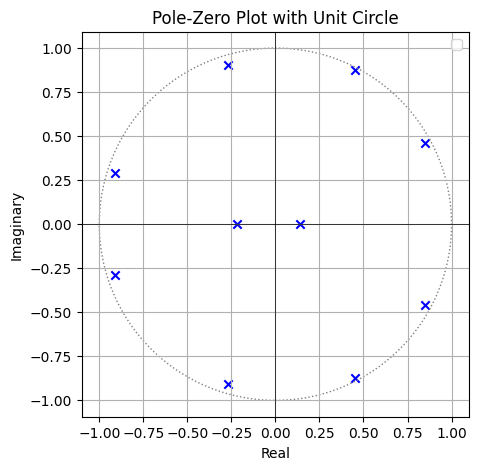

In [255]:
#POLE ZERO PLOT FOR P=10
p=np.roots([1, -0.15581751, 0.03421939, 0.50329878,  -0.04388539, 0.33204932,
 0.08209565,  -0.12277685, 0.72207599, 0.06275083,  -0.02238496])
plt.scatter(p.real, p.imag, color='blue', marker='x')
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='dotted')
plt.gca().add_patch(circle)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid()
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.legend()
plt.title('Pole-Zero Plot with Unit Circle')
plt.axis('equal')  # Make the aspect ratio equal for the plot
plt.show()

COMMENTS:

Transfer function $H(z)= \frac{1}{(1-r e^{-jθ}z^{-1})(1-r e^{+jθ}z^{-1})} = \frac{1}{1-2rcosθz^{-1}+r^{2}z^{-2}}$

We know that $r=e^{-\pi B_i T_s}$ and $θ=2 \pi F_1 T_s $

where $r e^{\pm j θ}$ are the poles of the denominator of the transfer function

Thus each pair of conjugate poles indicates a formant. Thus, when p=6, there are two major formant peaks while for p=10, there are 4 major formant peaks as can be seen in the next section.

When the magnitude of the poles is smaller (farther from unit circle) as in the p=6 case, we know that r is lesser so bandwidth is higher (slower decay after peak)  while for p=10 the magnitude of the poles is closer to 1 so bandwidth is lesser (fast decay after peak). This a more accurate estimation.

We can calculate the formants and bandwidth using the pole plot.




#5. Compute the gain and plot the LPC spectrum magnitude (i.e. the dB magnitude frequency response of the estimated all-pole filter) for each order "p". Comment on the characteristics of the spectral envelope estimates. Comment on their shapes with reference to the short-time magnitude spectrum computed in part 2.


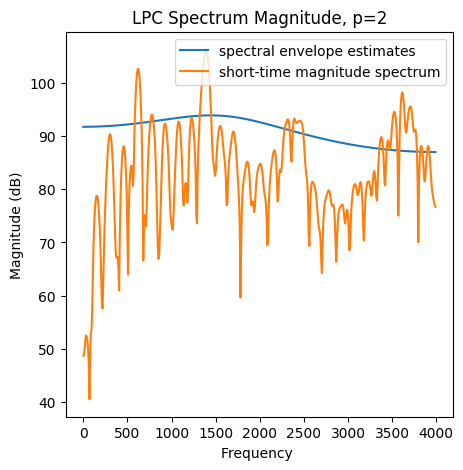

In [264]:
#LPC spectrum magnitude (i.e. the dB magnitude frequency response of the estimated all-pole filter) for p=2
p = [coeffs[2][0],*(-coeffs[2][1:3])]
w_est,h_est = signal.freqz(np.sqrt(energy[2]),p)
w_win,h_win = signal.freqz(win)

plt.plot((8000*w_est/(2*3.14159265)),20*np.log10(abs(h_est)),label="spectral envelope estimates")
plt.plot((8000*w_win/(2*3.14159265)),20*np.log10(abs(h_win)),label="short-time magnitude spectrum")
plt.title("LPC Spectrum Magnitude, p=2")

plt.xlabel("Frequency ")
plt.ylabel("Magnitude (dB)")
plt.legend(loc='upper right')


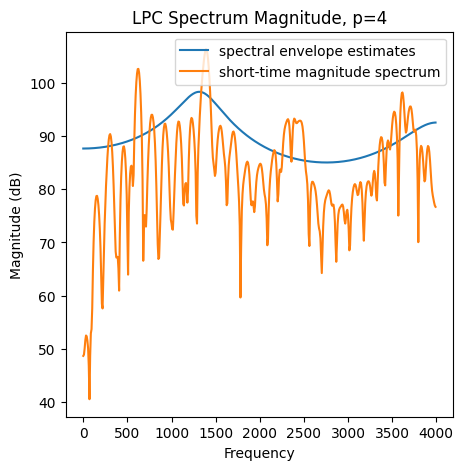

In [265]:
#LPC spectrum magnitude (i.e. the dB magnitude frequency response of the estimated all-pole filter) for p=4
p = [coeffs[4][0],*(-coeffs[4][1:5])]
w_est,h_est = signal.freqz(np.sqrt(energy[4]),p)
w_win,h_win = signal.freqz(win)

plt.plot((8000*w_est/(2*3.14159265)),20*np.log10(abs(h_est)),label="spectral envelope estimates")
plt.plot((8000*w_win/(2*3.14159265)),20*np.log10(abs(h_win)),label="short-time magnitude spectrum")
plt.title("LPC Spectrum Magnitude, p=4")

plt.xlabel("Frequency")
plt.ylabel("Magnitude (dB)")
plt.legend(loc='upper right')

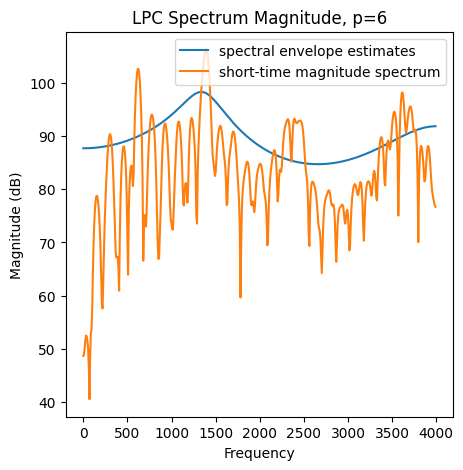

In [266]:
#LPC spectrum magnitude (i.e. the dB magnitude frequency response of the estimated all-pole filter) for p=6
p = [coeffs[6][0],*(-coeffs[6][1:7])]
w_est,h_est = signal.freqz(np.sqrt(energy[6]),p)
w_win,h_win = signal.freqz(win)

plt.plot((8000*w_est/(2*3.14159265)),20*np.log10(abs(h_est)),label="spectral envelope estimates")
plt.plot((8000*w_win/(2*3.14159265)),20*np.log10(abs(h_win)),label="short-time magnitude spectrum")
plt.title("LPC Spectrum Magnitude, p=6")

plt.xlabel("Frequency")
plt.ylabel("Magnitude (dB)")
plt.legend(loc='upper right')

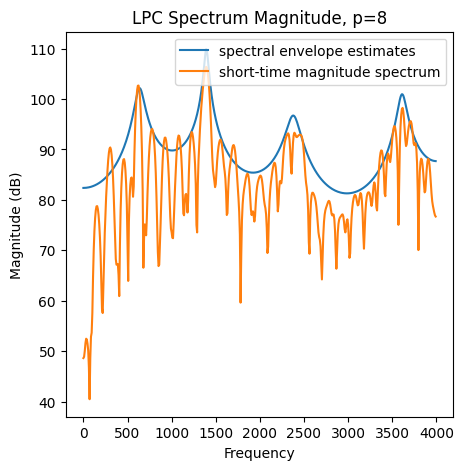

In [267]:
#LPC spectrum magnitude (i.e. the dB magnitude frequency response of the estimated all-pole filter) for p=8
p = [coeffs[8][0],*(-coeffs[8][1:9])]
w_est,h_est = signal.freqz(np.sqrt(energy[6]),p)
w_win,h_win = signal.freqz(win)

plt.plot((8000*w_est/(2*3.14159265)),20*np.log10(abs(h_est)),label="spectral envelope estimates")
plt.plot((8000*w_win/(2*3.14159265)),20*np.log10(abs(h_win)),label="short-time magnitude spectrum")
plt.title("LPC Spectrum Magnitude, p=8")

plt.xlabel("Frequency")
plt.ylabel("Magnitude (dB)")

plt.legend(loc='upper right')

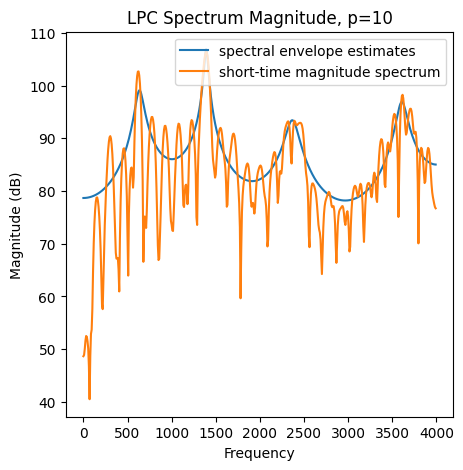

In [268]:
#LPC spectrum magnitude (i.e. the dB magnitude frequency response of the estimated all-pole filter) for p=10
p = [coeffs[10][0],*(-coeffs[10][1:11])]
w_est,h_est = signal.freqz(np.sqrt(energy[10]),p)
w_win,h_win = signal.freqz(win)

plt.plot((8000*w_est/(2*3.14159265)),20*np.log10(abs(h_est)),label="spectral envelope estimates")
plt.plot((8000*w_win/(2*3.14159265)),20*np.log10(abs(h_win)),label="short-time magnitude spectrum")
plt.title("LPC Spectrum Magnitude, p=10")

plt.xlabel("Frequency")
plt.ylabel(r"Magnitude (dB)")
plt.legend(loc='upper right')

COMMENTS:

As P (order of LP coeffs) increases, the estimation matches the formants of the windowed spectrum more closely, especially at the peaks.

Gain, which is obtained by square root of the energy array printed above, also decreases as p increases.

Since no. of estimated formants depend on the no. of conjugate poles, we can see that p=2 has one peak while p=4, 6 have 2 and p=8,10 have 4 peaks.

#6. Based on the 10th-order LP coefficients, carry out the inverse filtering of the /a/ vowel segment to obtain the residual error signal. Can you measure the pitch period of the voiced sound from the residual waveform? Use the acf to detect the pitch. Compare the acf plots of the original speech and residual signals

240


Text(0.5, 0, 'Amplitude')

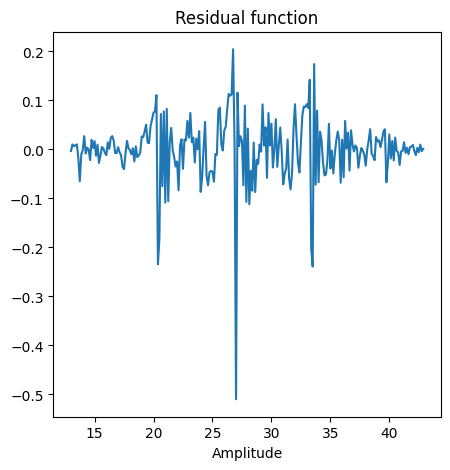

In [276]:
#Inverse filtering (eliminate formant info but keep harmonics) to calculate residual function
print(len(win))
x=np.zeros(240)
for i in range(240):
  if (i<10):
    x[i]= win[i]
  else:
    x[i]= 1*win[i] -0.15581751*win[i-1] +0.03421939*win[i-2] +0.50329878*win[i-3] -0.04388539*win[i-4] +0.33204932*win[i-5] +0.08209565*win[i-6] -0.12277685*win[i-7] +0.72207599*win[i-8] +0.06275083*win[i-9] -0.02238496*win[i-10]
x=x/np.sqrt(energy[10])
t=np.arange(13,43,0.125)
plt.plot(t,x)
plt.title('Residual function')
plt.xlabel('time(ms)')
plt.xlabel('Amplitude')

479


Text(0, 0.5, 'Magnitude')

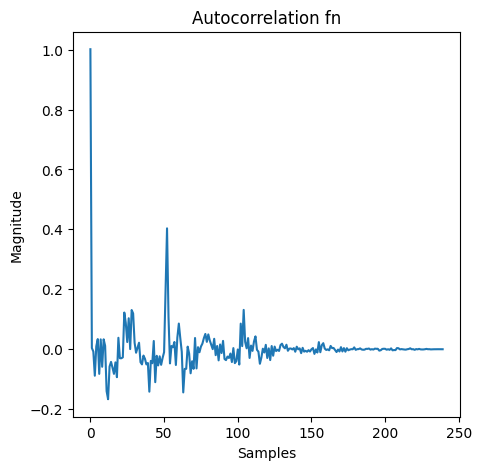

In [284]:
#Calculating autocorrelation of residual function to get pitch period
acf=np.correlate(x,x,mode='full')
print(len(acf))
acffinal=acf[239:]
plt.plot(acffinal)
plt.title('Autocorrelation fn')
plt.xlabel("Samples")
plt.ylabel("Magnitude")

In [285]:
#Second highest peak
removemax=acffinal[acffinal<0.5*np.max(acffinal)]
secondmax= np.argmax(removemax)
print(secondmax)

51


In [279]:
print("Pitch period=",51*0.03/240,"s")

Pitch period= 0.0063750000000000005 s


In [280]:
print("Pitch=",1/0.006375,"Hz")

Pitch= 156.86274509803923 Hz


479


Text(0, 0.5, 'Magnitude')

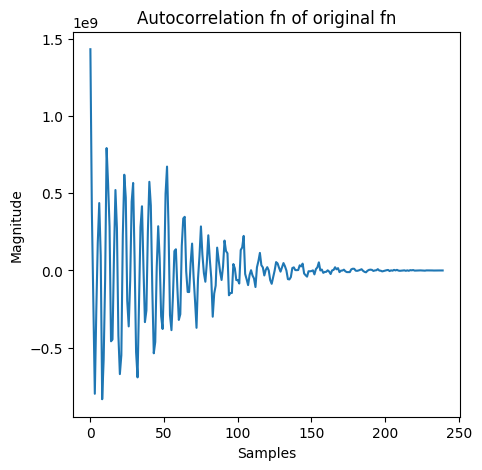

In [282]:
#Calculating autocorrelation of original function
acf=np.correlate(win,win,mode='full')
print(len(acf))
acffinal=acf[239:]
plt.plot(acffinal)
plt.title('Autocorrelation fn of original fn')
plt.xlabel("Samples")
plt.ylabel("Magnitude")

COMMENTS:

The autocorrelation function of the original waveform contains both formant and pitch info, so it is hard to extract pitch info from it, there are no distinct peaks. However, after inverse filtering, we essentially remove the formant information by taking the inverse of the vocal tract filter. Thus, only pitch info is present in the residual waveform, and the autocorrelation gives us a distinct peak corresponding to the pitch period of the voicing, so yes we can calculate the fundamental frequency from this. (Without using autocorrelation, you can directly use the distance between peaks of the residual waveform to estimate the F0)

Pitch period is 63.75 ms and the pitch is 156.863 Hz
I Calculated it by taking the distance between the highest and second highest peaks of the Autocorrelation function of the residual signal.


#7. LP re-synthesis: We analysed a natural speech sound /uh/ above. Using a suitable set of parameter estimates as obtained there, we wish to reconstruct the sound. That is, use the best estimated LP filter with an ideal impulse train of the estimated pitch period as source excitation. Carry out de-emphasis on the output waveform. Set the duration of the synthesized sound to be 300 ms at 8 kHz sampling frequency and view the waveform as well as listen to your created sound. Comment on the similarity with the original sound. Try out voice modification using this analysis-synthesis method (e.g. change the voice pitch).

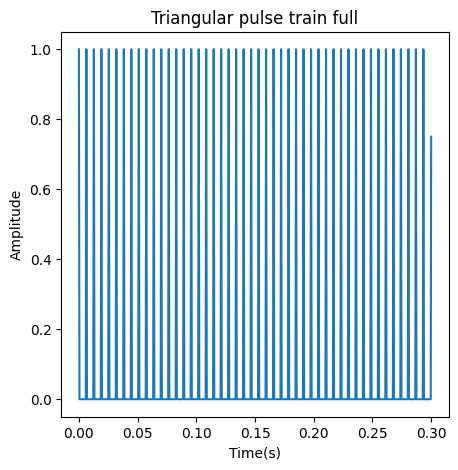

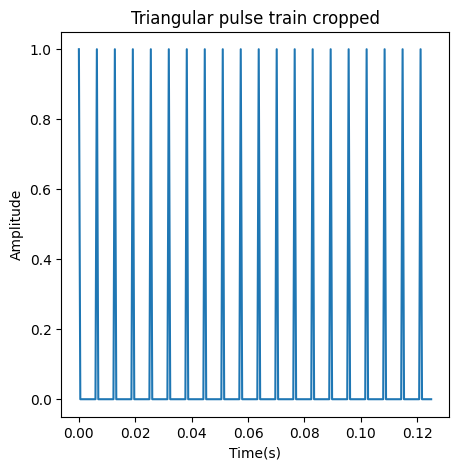

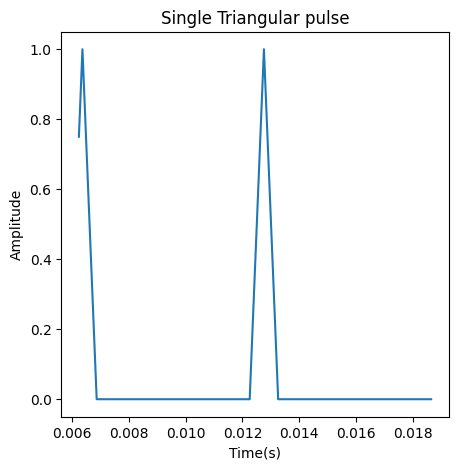

In [288]:
#GENERATING THE IMPULSE TRAIN FOR 300ms at 8Khz sampling for 156.7 Hz
import scipy.signal as signal
from IPython.display import Audio, display

arr=[]
for i in range(47):
  arr.append(int(i*51))
#Generating a triangular pulse for 47 samples in an array of 2400 samples, so when sampling rate is 8000 Hz, the signal frequency will be 156.67 Hz
#plotting on the time axis, for sampling rate  8000, there will be 2400 samples in 0.3 seconds
t=np.linspace(0,0.3,2400)
imp=np.zeros(2400)
for i in range (2400):
  if i in arr:
      imp[i]=1
      imp[i-3]=1/4
      imp[i-2]=1/2
      imp[i-1]=3/4
      imp[i+3]=1/4
      imp[i+2]=1/2
      imp[i+1]=3/4
plt.plot(t, imp)
#labelling graph
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title('Triangular pulse train full')
plt.show()
plt.plot(t[:1000], imp[:1000])
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title('Triangular pulse train cropped')
plt.show()
plt.plot(t[50:150], imp[50:150])
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title('Single Triangular pulse')
plt.show()

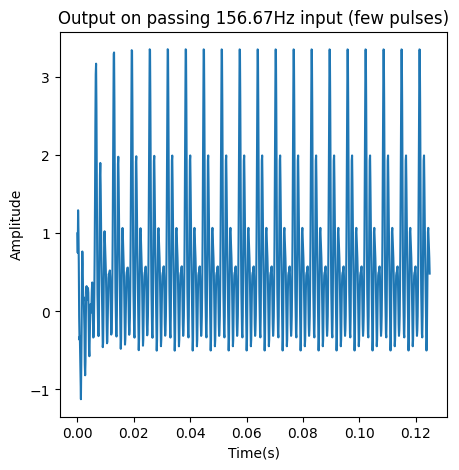

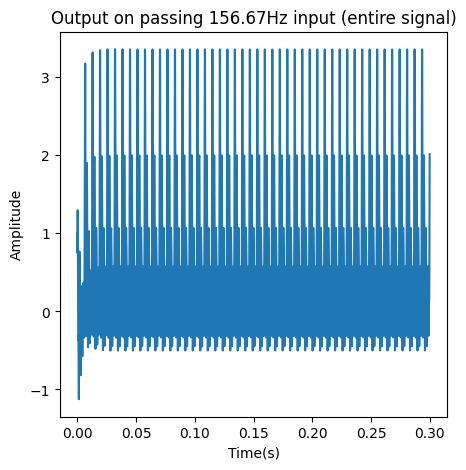

In [293]:
#Filtering this using the predicted linear filter
out=np.zeros_like(imp)
for i in range(2400):
  if (i==0 or i==1):
    out[i]=imp[i]
  else:
    out[i]=(imp[i] +0.15581751*out[i-1] -0.03421939*out[i-2] -0.50329878*out[i-3] +0.04388539*out[i-4] -0.33204932*out[i-5] -0.08209565*out[i-6] +0.12277685*out[i-7] -0.72207599*out[i-8] -0.06275083*out[i-9] +0.02238496*out[i-10])
deemphasis=np.zeros_like(imp)
for i in range(2400):
  if (i==0 or i==1):
    deemphasis[i]=out[i]
  else:
    deemphasis[i]=out[i] +0.95*deemphasis[i-1]

#plotting the output of the filter
t=np.linspace(0,0.3,2400)
plt.plot(t[:1000], deemphasis[:1000])
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title('Output on passing 156.67Hz input (few pulses)')
plt.show()
plt.plot(t, deemphasis)
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title('Output on passing 156.67Hz input (entire signal)')
plt.show()

In [171]:
#Conversion to audio
Audio(np.asfarray(deemphasis),rate=8000)

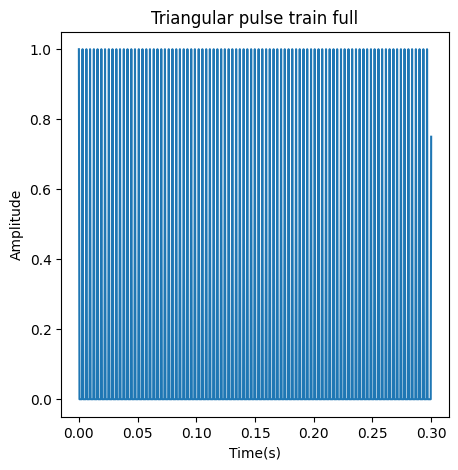

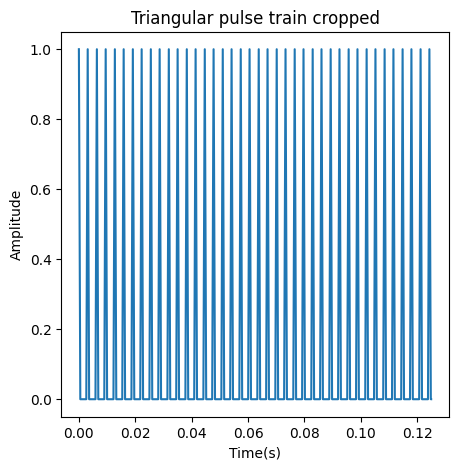

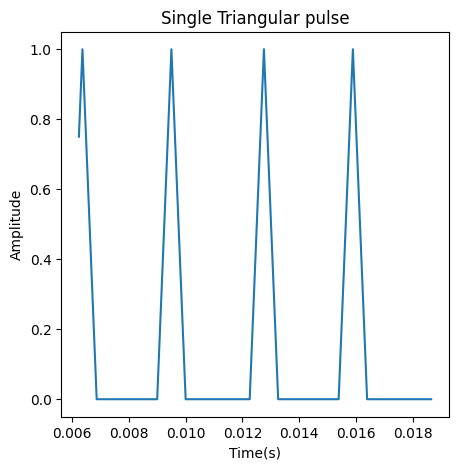

In [295]:
#DOUBLING THE FREQUENCY OF THE GENERATED VOWEL
import scipy.signal as signal
from IPython.display import Audio, display

arr=[]
for i in range(94):
  arr.append(int(i*25.5))
#plotting on the time axis, for sampling rate 16000, there will be 10000 samples in 0.625 seconds
t=np.linspace(0,0.3,2400)
impdoub=np.zeros(2400)
for i in range (2400):
  if i in arr:
      impdoub[i]=1
      impdoub[i-3]=1/4
      impdoub[i-2]=1/2
      impdoub[i-1]=3/4
      impdoub[i+3]=1/4
      impdoub[i+2]=1/2
      impdoub[i+1]=3/4
plt.plot(t, impdoub)
#labelling graph
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title('Triangular pulse train full')
plt.show()
plt.plot(t[:1000], impdoub[:1000])
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title('Triangular pulse train cropped')
plt.show()
plt.plot(t[50:150], impdoub[50:150])
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title('Single Triangular pulse')
plt.show()

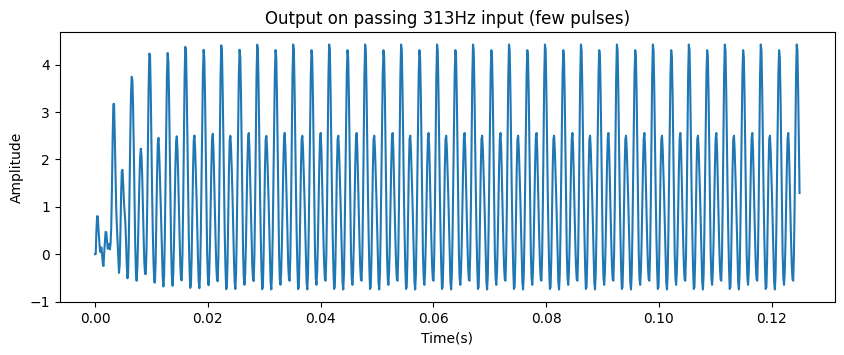

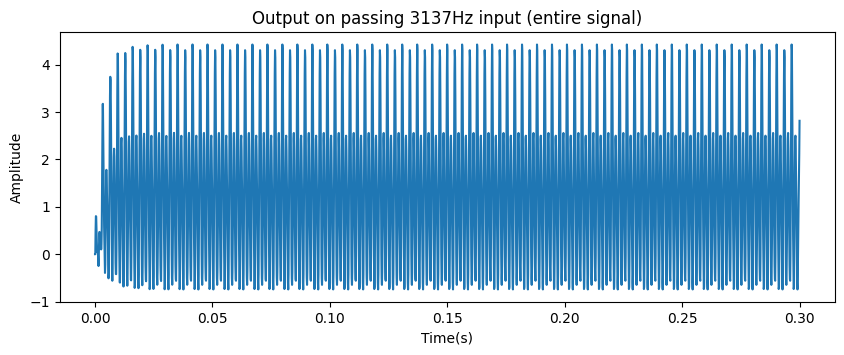

In [331]:
#Filtering to get the vowel
out=np.zeros_like(impdoub)
for i in range(2400):
  if (i==0 or i==1):
    out[i]=0
  else:
    out[i]=(impdoub[i] +0.15581751*out[i-1] -0.03421939*out[i-2] -0.50329878*out[i-3] +0.04388539*out[i-4] -0.33204932*out[i-5] -0.08209565*out[i-6] +0.12277685*out[i-7] -0.72207599*out[i-8] -0.06275083*out[i-9] +0.02238496*out[i-10])
deemphasis=np.zeros_like(impdoub)
for i in range(2400):
  if (i==0 or i==1):
    deemphasis[i]=out[i]
  else:
    deemphasis[i]=out[i] +0.95*deemphasis[i-1]

#plotting the output of the filter
t=np.linspace(0,0.3,2400)
plt.plot(t[:1000], deemphasis[:1000])
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title('Output on passing 313Hz input (few pulses)')
plt.show()
plt.plot(t, deemphasis)
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title('Output on passing 3137Hz input (entire signal)')
plt.show()

In [330]:
#Conversion to audio
Audio(np.asfarray(deemphasis),rate=8000)

COMMENTS:

The first sound is similar to the speech sound, but it is less muffled as the impulse train is a sharp triangualr pulse train and not a soft glottal pulse train. Also, there isnt added channel noise in the generated signal as there would be in a recorded speech signal.

The second sound is created by doubling the frequency if the first sound.

The first sound has been generated by filtering an impulse train of the same frequency as the sound voicing through a filter made by the predicted LP coefficiants which gave the formants,.


# Optional (for bonus marks): Perform LP analysis on the provided /s/ sound (sampled at 16 kHz).

In [332]:
read = wavfile.read('/content/drive/MyDrive/Colab Notebooks/Speech/ss.wav')
Fs = read[0]
inp = read[1]

1489


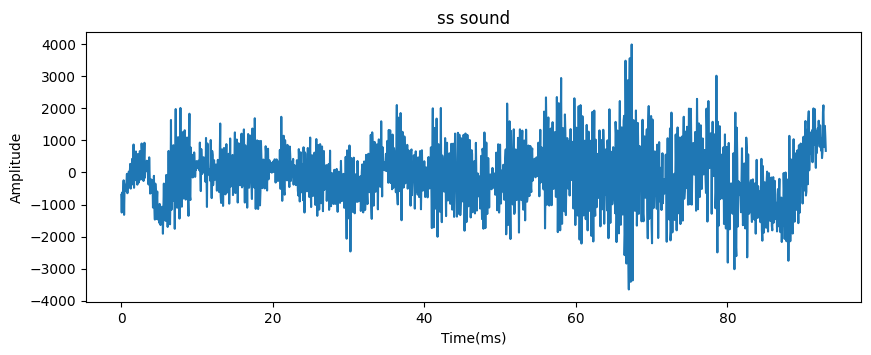

In [333]:
print (len(inp))
t=np.arange(0,93.05,0.0625)
plt.plot(t,inp)
#labelling graph
plt.xlabel('Time(ms)')
plt.ylabel('Amplitude')
plt.title('ss sound')

Audio(np.asfarray(inp),rate=16000)

In [334]:
#Loop for difference equation
pe=np.zeros_like(inp)
for i in range(1489):
  if (i==0 or i==1):
    pe[i]=inp[i]
  else:
    pe[i]=(inp[i]-0.95*inp[i-1])

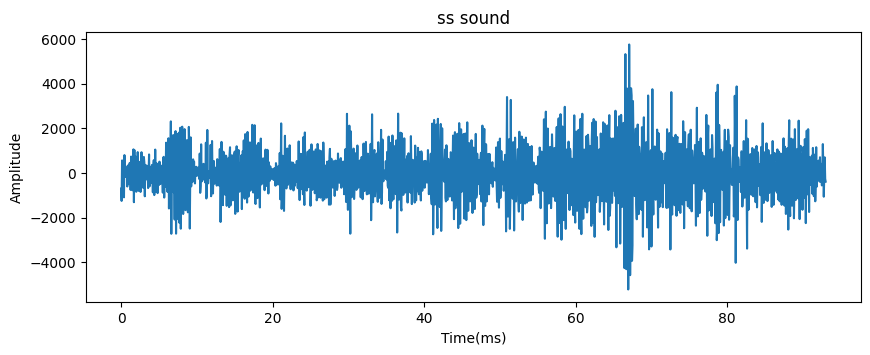

In [335]:
plt.plot(t,pe)
#labelling graph
plt.xlabel('Time(ms)')
plt.ylabel('Amplitude')
plt.title('ss sound')

Audio(np.asfarray(pe),rate=16000)

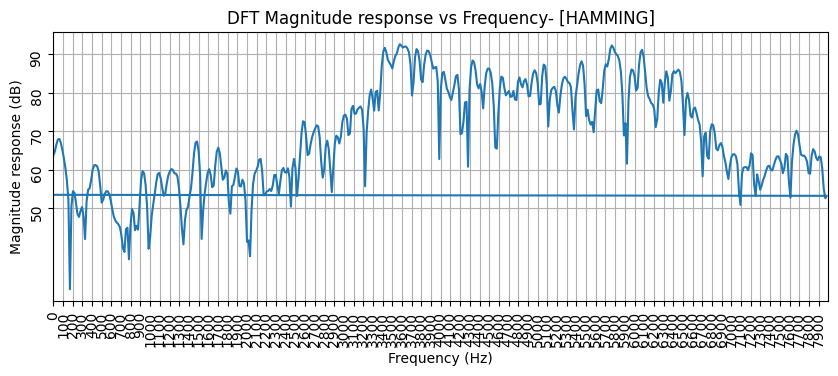

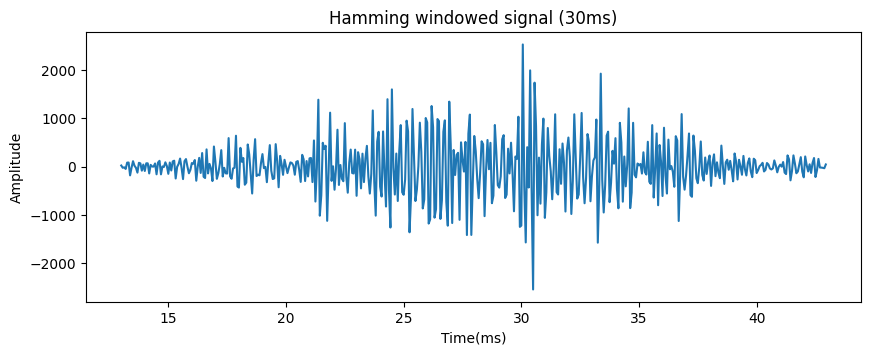

In [336]:
clip=pe[204:684]
samples=int(0.03*16000)
win=clip*np.hamming(samples)

dft=np.fft.fft(win,1024)
freq=np.fft.fftfreq(dft.shape[-1],0.0000625)

#scaling axes (Y axis in decibel and x axis using sampling frequency)
plt.rcParams["figure.figsize"] = [10, 3.50]
plt.plot(freq,20*np.log10(np.abs(dft)))
#labelling graph
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude response (dB)')
plt.title('DFT Magnitude response vs Frequency- [HAMMING]')
plt.xlim(0,8000)
plt.xticks(np.arange(0,8000,100),rotation='vertical')
plt.yticks(np.arange(50,100,10),rotation='vertical')
plt.grid("True")
plt.show()

t=np.arange(13,43,0.0625)
#scaling axes (Y axis in decibel and x axis using sampling frequency)
plt.rcParams["figure.figsize"] = [10, 3.50]
plt.plot(t,win)
#labelling graph
plt.xlabel('Time(ms)')
plt.ylabel('Amplitude')
plt.title('Hamming windowed signal (30ms)')
plt.show()

959


Text(0, 0.5, 'magnitude')

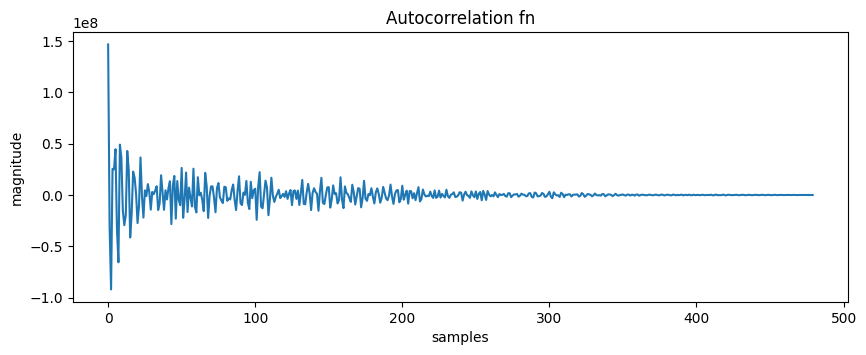

In [337]:
acf=np.correlate(win,win,mode='full')
print(len(acf))
acffinal=acf[479:]
plt.plot(acffinal)
plt.title('Autocorrelation fn')
plt.xlabel('samples')
plt.ylabel('magnitude')

In [338]:
energy = np.zeros(11) #Energy
coeffs = np.zeros((11,11)) #LP Coeffs
for i in range (11):
 if (i==0):
  energy[i]=acffinal[i]
  coeffs[i][0] = 1
 elif (i==1):
  energy[i] = (1-(acffinal[i]/energy[i-1])**2)*energy[i-1]
  coeffs[i][i] = acffinal[i]/energy[i-1]
  coeffs[i][0] = 1
 else:
  sum1 = 0
  for j in range(1, i):
   sum1 = sum1 + acffinal[i-j]*coeffs[i-1][j]
  energy[i] = (1-((acffinal[i] - sum1)/energy[i-1])**2)*energy[i-1]
  coeffs[i][i] = (acffinal[i] - sum1)/energy[i-1]
  for j in range(1, i):
   coeffs[i][j] = coeffs[i-1][j] - ((acffinal[i] - sum1)/energy[i-1]) * coeffs[i-1][i-j]
  coeffs[i][0] = 1

print('p=2 coeffs:',coeffs[2])
print('p=2 energy:',energy[2])
print('p=4 coeffs:',coeffs[4])
print('p=4 energy:',energy[4])
print('p=6 coeffs:',coeffs[6])
print('p=6 energy:',energy[6])
print('p=8 coeffs:',coeffs[8])
print('p=8 energy:',energy[8])
print('p=10 coeffs:',coeffs[10])
print('p=10 energy:',energy[10])

p=2 coeffs: [ 1.         -0.3539327  -0.70128097  0.          0.          0.
  0.          0.          0.          0.          0.        ]
p=2 energy: 71320971.70612586
p=4 coeffs: [ 1.         -0.95872626 -1.52679012 -0.91455252 -0.81164128  0.
  0.          0.          0.          0.          0.        ]
p=4 energy: 20448292.33267381
p=6 coeffs: [ 1.         -1.03752113 -1.83682496 -1.30877229 -1.32190196 -0.35397886
 -0.27674358  0.          0.          0.          0.        ]
p=6 energy: 18783253.2136794
p=8 coeffs: [ 1.         -0.95061167 -1.71187383 -0.83982058 -0.81386489  0.34545567
  0.16523006  0.39916511  0.03781142  0.          0.        ]
p=8 energy: 16274783.838291312
p=10 coeffs: [ 1.         -0.93755873 -1.78167456 -0.80402868 -0.86155918  0.58760281
  0.28007524  0.72138195  0.09400837  0.14667991 -0.09311428]
p=10 energy: 15234894.534869224


Text(0.5, 1.0, 'Error Signal Energy vs Poles')

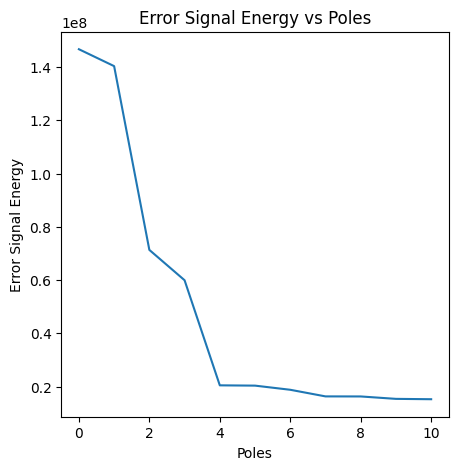

In [339]:
p = [0,1,2,3,4,5,6,7,8,9,10]
plt.rcParams["figure.figsize"] = [5,5]
plt.plot(p,energy)
plt.xlabel("Poles")
plt.ylabel("Error Signal Energy")
plt.title("Error Signal Energy vs Poles")

Text(0.5, 1.0, 'Error Signal Energy(dB) vs Poles')

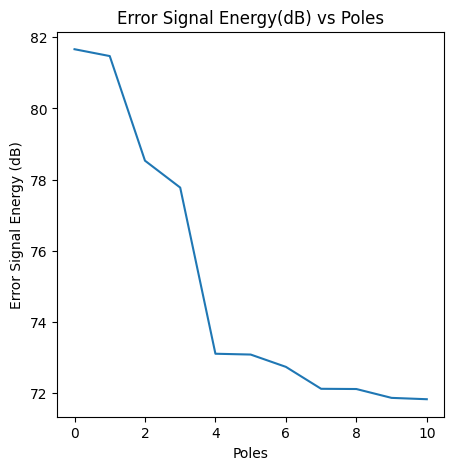

In [340]:
p = [0,1,2,3,4,5,6,7,8,9,10]
plt.rcParams["figure.figsize"] = [5,5]
plt.plot(p,10*np.log10(energy))
plt.xlabel("Poles")
plt.ylabel("Error Signal Energy (dB)")
plt.title("Error Signal Energy(dB) vs Poles")


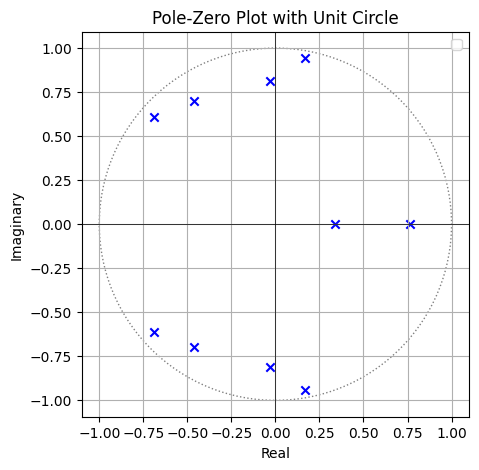

In [341]:
p=np.roots([1, +0.93755873, +1.78167456, +0.80402868, +0.86155918,  -0.58760281,
  -0.28007524,  -0.72138195,  -0.09400837,  -0.14667991, +0.09311428])

plt.scatter(p.real, p.imag, color='blue', marker='x')
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='dotted')
plt.gca().add_patch(circle)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid()
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.legend()
plt.title('Pole-Zero Plot with Unit Circle')
plt.axis('equal')  # Make the aspect ratio equal for the plot
plt.show()

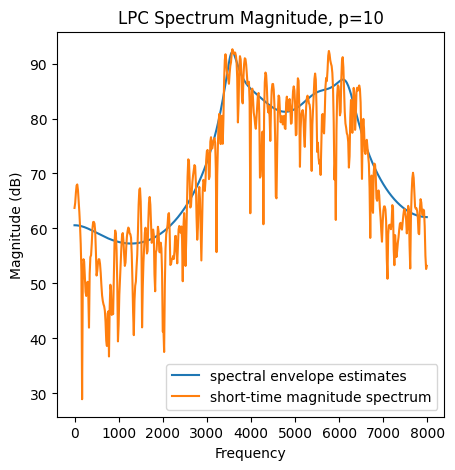

In [342]:
p = [coeffs[10][0],*(-coeffs[10][1:11])]
w_est,h_est = signal.freqz(np.sqrt(energy[10]),p)
w_win,h_win = signal.freqz(win)

plt.plot((16000*w_est/(2*3.14159265)),20*np.log10(abs(h_est)),label="spectral envelope estimates")
plt.plot((16000*w_win/(2*3.14159265)),20*np.log10(abs(h_win)),label="short-time magnitude spectrum")
plt.title("LPC Spectrum Magnitude, p=10")

plt.xlabel("Frequency")
plt.ylabel(r"Magnitude (dB)")
plt.legend(loc='lower right')

480


Text(0.5, 0, 'Amplitude')

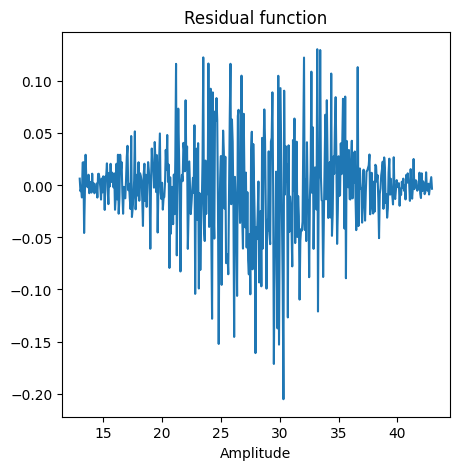

In [343]:
print(len(win))
x=np.zeros(480)
for i in range(480):
  if (i<10):
    x[i]= win[i]
  else:
    x[i]= 1*win[i] +0.93755873*win[i-1] +1.78167456*win[i-2] +0.80402868*win[i-3] +0.86155918*win[i-4] -0.58760281*win[i-5] -0.28007524*win[i-6] -0.72138195*win[i-7] -0.09400837*win[i-8] -0.14667991*win[i-9] +0.09311428*win[i-10]
x=x/np.sqrt(energy[10])
t=np.arange(13,43,0.0625)
plt.plot(t,x)
plt.title('Residual function')
plt.xlabel('time(ms)')
plt.xlabel('Amplitude')

959


Text(0, 0.5, 'Magnitude')

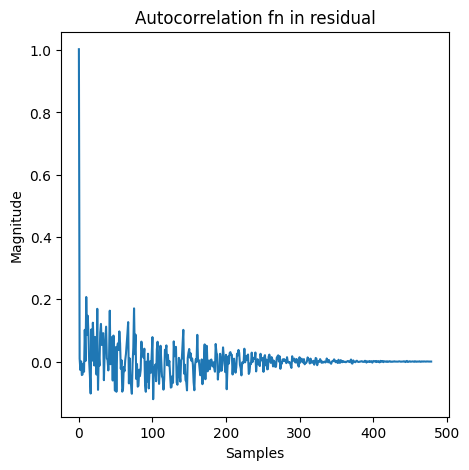

In [344]:
acf=np.correlate(x,x,mode='full')
print(len(acf))
acffinal=acf[479:]
plt.plot(acffinal)
plt.title('Autocorrelation fn in residual')
plt.xlabel("Samples")
plt.ylabel("Magnitude")

959


Text(0, 0.5, 'Magnitude')

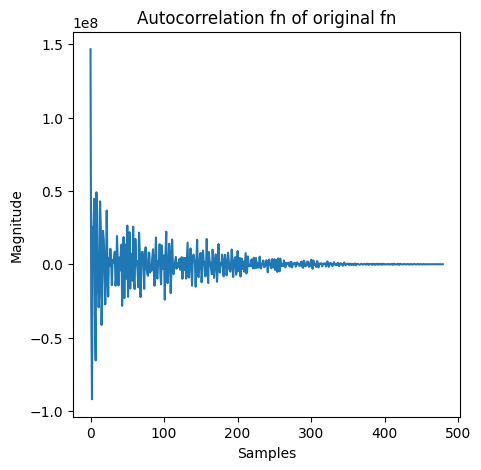

In [345]:
acf=np.correlate(win,win,mode='full')
print(len(acf))
acffinal=acf[479:]
plt.plot(acffinal)
plt.title('Autocorrelation fn of original fn')
plt.xlabel("Samples")
plt.ylabel("Magnitude")

COMMENTS:

We cannot recreate this signal by the previous method because it is unvoiced so an impulse train wont be able to recreate it.

We can also see that there are no distinct peaks in the autocorrelation functions of the original as well as residual /s/ sound since the sound does not have voicing.

The tenth order LPC estimates the formants very well and its pole plot has been displayed. S will also have zeros but these have been modeled as poles here as the presence of a zero is similar to the presence of poles surrounding that region but not at that region.

In [346]:
%%shell
jupyter nbconvert --to html /content/Speechass1b_20d070009.ipynb

[NbConvertApp] WARNING | pattern '/content/Speechass1b_20d070009.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=

CalledProcessError: ignored